# Overview

The aim of this project is to train a model to filter spam messages. It's a classic example when talking about Natural Language Processing and we found interesting working on it for our first NLP project.

Our group is composed of:

- Bryan Tchakote (PGE 4)
- Daniela Wouelebak (PGE 4)
- Stella Detio (PGE 4)

Without further delay let's dive into it!

# Read and explore the data

In [1]:
import pandas as pd
df = pd.read_csv('SMSSpamCollection.tsv', sep='\t', header=None)
df.head()

,0,1
0,ham,I've been searching for the right words to tha...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,ham,Even my brother is not like to speak with me. ...
4,ham,I HAVE A DATE ON SUNDAY WITH WILL!!


In [2]:
print(f'{df.shape[0]} rows, {df.shape[1]} columns.')

5568 rows, 2 columns.


In [3]:
# Rename the columns
df.columns = ['type', 'text']

In [4]:
# Checking for missing data
df.isnull().any()

type    False
text    False
dtype: bool

No missing data.

In [5]:
# Getting the target variable (class) distribution
pd.concat([df.type.value_counts(), df.type.value_counts(normalize=True)], axis=1, keys=['count', 'pct'])

,count,pct
ham,4822,0.86602
spam,746,0.13398


Unbalanced data: much more ham messages than spam.

In [6]:
# Data splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[['text']], df[['type']], test_size=.2, random_state=42, stratify=df[['type']])

# Feature engineering

Here we're going to add three new features to our data: the message length and the punctuation and uppercase characters percentage.

In [7]:
# Message length
X_train['text_len'] = X_train.text.apply(lambda x: len(x) - x.count(' '))

In [8]:
# Punctuation percentage
import re
import string
X_train['punct_pct'] = [len(re.findall(f'[{string.punctuation}]', text)) / (len(text) - text.count(' ')) for text in X_train.text]

In [9]:
# Uppercase percentage
X_train['upper_pct'] = [len(re.findall('[A-Z]', text)) / (len(text) - text.count(' ')) for text in X_train.text]

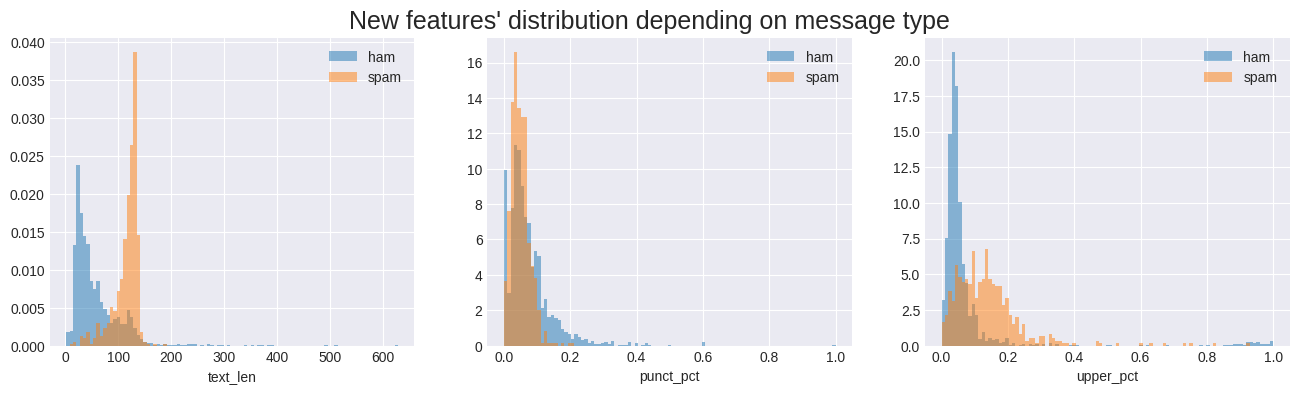

In [10]:
# Let's now evaluate our new features by plotting them
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
plot_data = pd.concat([X_train, y_train], axis=1)
for i in range(3):
    bins = np.linspace(plot_data.iloc[:, i+1].min(), plot_data.iloc[:, i+1].max(), 100)
    ax[i].hist(plot_data.query('type == "ham"').iloc[:, i+1], bins=bins, density=True, alpha=0.5, label='ham')
    ax[i].hist(plot_data.query('type == "spam"').iloc[:, i+1], bins=bins, density=True, alpha=0.5, label='spam')
    ax[i].set_xlabel(plot_data.columns[i+1])
    ax[i].legend()
plt.suptitle('New features\' distribution depending on message type', y=.95, fontsize=18)
plt.show()

- According to the message length's distribution, spams seem to be longer than normal messages
- Spams are also more likely to contain a lot of uppercase characters 
- All of the distributions above are right-skewed, we're going to use a Log Transformation to reduce that noise

In [11]:
# Log transformation
## Since log(0) is -inf, we replace 0 by the min value greater than 0
## for each variable before applying the log function
text_len_positive_min = X_train.query('text_len > 0').text_len.min()
punct_pct_positive_min = X_train.query('punct_pct > 0').punct_pct.min()
upper_pct_positive_min = X_train.query('upper_pct > 0').upper_pct.min()

X_train.loc[X_train.text_len == 0, 'text_len'] = text_len_positive_min
X_train.loc[X_train.punct_pct == 0, 'punct_pct'] = punct_pct_positive_min
X_train.loc[X_train.upper_pct == 0, 'upper_pct'] = upper_pct_positive_min

X_train['text_len_log'] = np.log(X_train.text_len)
X_train['punct_pct_log'] = np.log(X_train.punct_pct)
X_train['upper_pct_log'] = np.log(X_train.upper_pct)

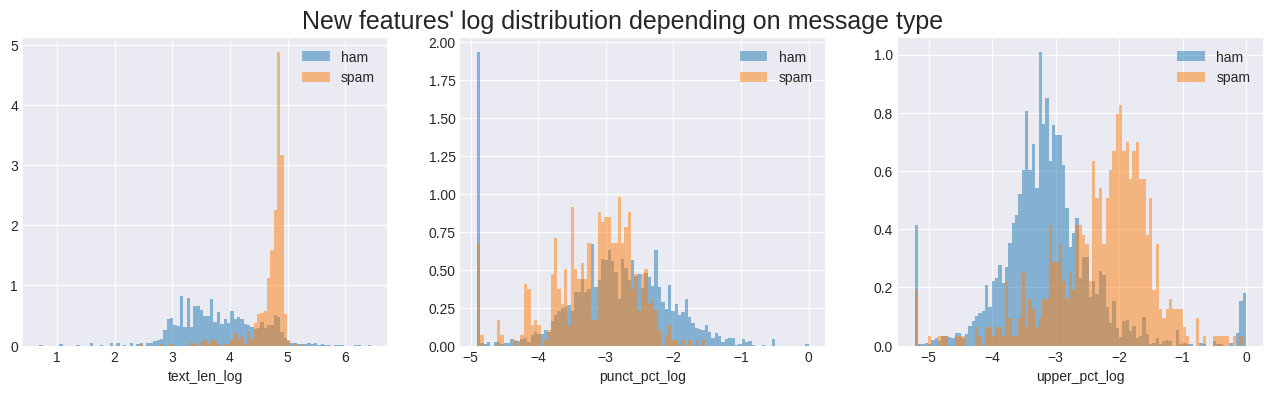

In [12]:
# Visualize the transformed data
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
plot_data = pd.concat([X_train, y_train], axis=1)
for i in range(3):
    bins = np.linspace(plot_data.iloc[:, i+4].min(), plot_data.iloc[:, i+4].max(), 100)
    ax[i].hist(plot_data.query('type == "ham"').iloc[:, i+4], bins=bins, density=True, alpha=0.5, label='ham')
    ax[i].hist(plot_data.query('type == "spam"').iloc[:, i+4], bins=bins, density=True, alpha=0.5, label='spam')
    ax[i].set_xlabel(plot_data.columns[i+4])
    ax[i].legend()
plt.suptitle('New features\' log distribution depending on message type', y=.95, fontsize=18)
plt.show()

# Data Preprocessing

In [13]:
# Lowercase
X_train.text = X_train.text.str.lower()

In [14]:
# Unicode characters
unicode_pattern = '(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?'
X_train.text = [re.sub(unicode_pattern, ' ', text) for text in X_train.text]

In [15]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [16]:
# Stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
X_train.text = [[word for word in text.split() if word not in (stop)] for text in X_train.text]

In [17]:
# Lemmatizing
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
X_train.text = [' '.join([lemmatizer.lemmatize(word) for word in words]) for words in X_train.text]

In [18]:
# Text vectorizing (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train.text)
vectorized_text = pd.DataFrame(vectorizer.transform(X_train.text).toarray())

In [19]:
# Concatenating data
X_train = X_train.drop(columns=['text', 'text_len', 'punct_pct', 'upper_pct'])
X_train = pd.concat([X_train.reset_index().drop(columns='index'), vectorized_text], axis=1)
X_train = np.array(X_train)

In [20]:
# Target encoding
y_train.loc[y_train.type == 'ham', 'type'] = 0
y_train.loc[y_train.type == 'spam', 'type'] = 1
y_train = np.array(y_train).ravel()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

# Preprocessing Function

In [21]:
def preprocessing_pipeline(X, y):
    # Message length
    X['text_len'] = X.text.apply(lambda x: len(x) - x.count(' '))

    # Punctuation percentage
    X['punct_pct'] = [len(re.findall(f'[{string.punctuation}]', text)) / (len(text) - text.count(' ')) for text in X.text]

    # Uppercase percentage
    X['upper_pct'] = [len(re.findall('[A-Z]', text)) / (len(text) - text.count(' ')) for text in X.text]

    # Log transformation
    X.loc[X.text_len == 0, 'text_len'] = text_len_positive_min
    X.loc[X.punct_pct == 0, 'punct_pct'] = punct_pct_positive_min
    X.loc[X.upper_pct == 0, 'upper_pct'] = upper_pct_positive_min

    X['text_len_log'] = np.log(X.text_len)
    X['punct_pct_log'] = np.log(X.punct_pct)
    X['upper_pct_log'] = np.log(X.upper_pct)

    # Lowercase
    X.text = X.text.str.lower()

    # Unicode characters
    X.text = [re.sub(unicode_pattern, ' ', text) for text in X.text]

    # Stopwords
    X.text = [[word for word in text.split() if word not in (stop)] for text in X.text]

    # Lemmatizing
    X.text = [' '.join([lemmatizer.lemmatize(word) for word in words]) for words in X.text]

    # Text vectorizing (TF-IDF)
    vectorized_text = pd.DataFrame(vectorizer.transform(X.text).toarray())
    
    # Concatenating data
    X = X.drop(columns=['text', 'text_len', 'punct_pct', 'upper_pct'])
    X = pd.concat([X.reset_index().drop(columns='index'), vectorized_text], axis=1)
    X = np.array(X)
   
    # Target encoding
    y.loc[y.type == 'ham', 'type'] = 0
    y.loc[y.type == 'spam', 'type'] = 1
    y = np.array(y).ravel()
    y = le.transform(y)
    
    return X, y

# Model Training and Evaluation

In [22]:
%%time
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

parameters = {'n_estimators': [30, 50], 'max_depth': [6, 15], 'learning_rate': [.5, 1]}
xgb = XGBClassifier(objective='binary:logistic', booster='gbtree', eval_metric=log_loss,
                    tree_method='gpu_hist', gpu_id=0, random_state=42)
clf = GridSearchCV(xgb, parameters)
clf.fit(X_train, y_train)

X_test, y_test = preprocessing_pipeline(X_test, y_test)
y_pred = clf.predict(X_test)

CPU times: user 2min 48s, sys: 5.3 s, total: 2min 54s
Wall time: 2min


In [23]:
# Models ranking
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score').drop(columns=['params'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,2.576728,0.216744,0.045326,0.016079,0.5,6,50,0.984287,0.966330,0.983165,0.978676,0.971910,0.976874,0.006835,1
0,2.604518,0.672411,0.046081,0.015233,0.5,6,30,0.983165,0.964085,0.984287,0.978676,0.973034,0.976649,0.007427,2
3,3.009115,0.236859,0.044590,0.012189,0.5,15,50,0.980920,0.964085,0.980920,0.974186,0.969663,0.973955,0.006526,3
4,3.416990,0.920588,0.065166,0.041060,1,6,30,0.980920,0.964085,0.975309,0.974186,0.974157,0.973732,0.005433,4
5,2.785451,0.326274,0.045650,0.014765,1,6,50,0.980920,0.966330,0.977553,0.969697,0.973034,0.973507,0.005246,5
2,2.835508,0.196919,0.048342,0.016371,0.5,15,30,0.982043,0.958474,0.979798,0.975309,0.968539,0.972832,0.008533,6
6,2.735305,0.333144,0.037347,0.000997,1,15,30,0.976431,0.964085,0.978676,0.974186,0.966292,0.971934,0.005730,7
7,2.827663,0.441819,0.040537,0.003578,1,15,50,0.975309,0.962963,0.978676,0.976431,0.965169,0.971709,0.006373,8


In [24]:
# How are the features we've created important?
feature_importances = pd.DataFrame(clf.best_estimator_.feature_importances_)
n_words = len(vectorizer.get_feature_names_out())
features = ['text_len_log', 'punct_pct_log', 'upper_pct_log'] + list(range(n_words))
feature_importances.index = features
top_features = feature_importances[0].sort_values(ascending=False).reset_index().reset_index()
top_features.columns = ['rank', 'feature', 'importance']
top_features.loc[top_features.feature.isin(['text_len_log', 'upper_pct_log', 'punct_pct_log']), ['feature', 'importance', 'rank']]

,feature,importance,rank
5,text_len_log,0.043470,5
14,upper_pct_log,0.017974,14
49,punct_pct_log,0.005681,49


The new features we've added are in the top 50 features (out of 7000+). It wasn't bad to choose them.

In [25]:
# Model's performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
y_score = clf.predict_proba(X_test)

print('Accuracy:', round(accuracy_score(y_pred, y_test), 4))
print('Precision:', round(precision_score(y_pred, y_test), 4))
print('Recall:', round(recall_score(y_pred, y_test), 4))
print('F1 score:', round(f1_score(y_pred, y_test), 4))
print('AUC:', round(roc_auc_score(y_test, y_score[:, 1]), 4))

Accuracy: 0.9794
Precision: 0.8993
Recall: 0.9437
F1 score: 0.921
AUC: 0.9914


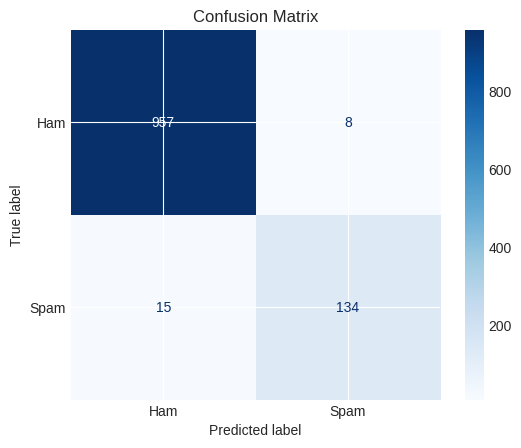

In [26]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

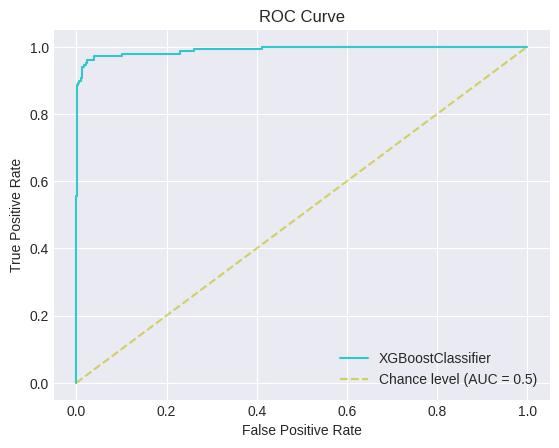

In [27]:
# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
plt.plot(fpr, tpr, 'c-', label='XGBoostClassifier', alpha=.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'y--', label='Chance level (AUC = 0.5)', alpha=.6)
plt.title('ROC Curve')
plt.legend()
plt.show()